# Oxford Pet Dataset Classification with ResNet34

This notebook demonstrates how to classify images from the Oxford-IIIT Pet Dataset using a modified ResNet34 model. We'll cover:

- **Data Loading**: Preparing the dataset with a custom class and data loaders.
- **Model Training**: Fine-tuning a pre-trained ResNet34 model with dropout and a custom classifier.
- **Testing and Evaluation**: Assessing the model's performance with metrics and visualizations.

## Prerequisites

- The Oxford-IIIT Pet Dataset should be uploaded to Colab or Google Drive.
- Required libraries: `torch`, `torchvision`, `PIL`, `sklearn`, `matplotlib`, `seaborn`.

Let’s get started!

## Some Imports and installation...bear with me

In [1]:


# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import datetime
import glob



## Let's download the dataset

In [2]:
!wget https://thor.robots.ox.ac.uk/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/pets/annotations.tar.gz

--2025-03-16 22:38:37--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   161MB/s    in 4.3s    

2025-03-16 22:38:42 (174 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2025-03-16 22:38:42--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  76.0MB/s    in 0.2s    

2025-03-16 22:38:42 (76.0 MB/s) 

# Hide annoying cell output

In [3]:
!pip install -q gwpy # this library i'm going to use to hide outputs of some cells that we don't to see the outpu/t of

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.2 MB/s eta 0:00:00


In [4]:
%%capture
!mkdir /content/data
!tar -xvzf images.tar.gz -C /content/data/
!tar -xvzf annotations.tar.gz -C /content/data/

In [5]:
data_dir = "/content/data/"

In [6]:
class OxfordPetDataset(Dataset):
    """Custom dataset for Oxford-IIIT Pet Dataset."""

    def __init__(self, img_dir, annotation_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_labels = []

        # Read annotation file (trainval.txt or test.txt)
        with open(annotation_file, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                img_name = parts[0] + ".jpg"  # Image file name
                label = int(parts[1]) - 1  # Convert to zero-based indexing
                self.image_labels.append((img_name, label))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_name, label = self.image_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # Open image as RGB

        if self.transform:
            image = self.transform(image)

        return image, label

def get_data_loaders(data_dir, batch_size=32, val_split=0.2):
    """Create data loaders for training, validation, and testing."""
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize to 224x224 (ResNet input size)
        transforms.RandomHorizontalFlip(),  # Randomly flip for augmentation
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
        transforms.RandomRotation(10),  # Rotate up to 10 degrees
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])

    img_dir = os.path.join(data_dir, "images")
    annotation_file = os.path.join(data_dir, "annotations/trainval.txt")
    test_annotation_file = os.path.join(data_dir, "annotations/test.txt")

    # Create datasets
    dataset = OxfordPetDataset(img_dir, annotation_file, transform)
    test_dataset = OxfordPetDataset(img_dir, test_annotation_file, transform)

    # Split into train and validation
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Test the data loaders (optional)
train_loader, val_loader, test_loader = get_data_loaders("/content/data/")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Train size: 2944, Validation size: 736, Test size: 3669


## Visualizing the transformations that we apply to the images

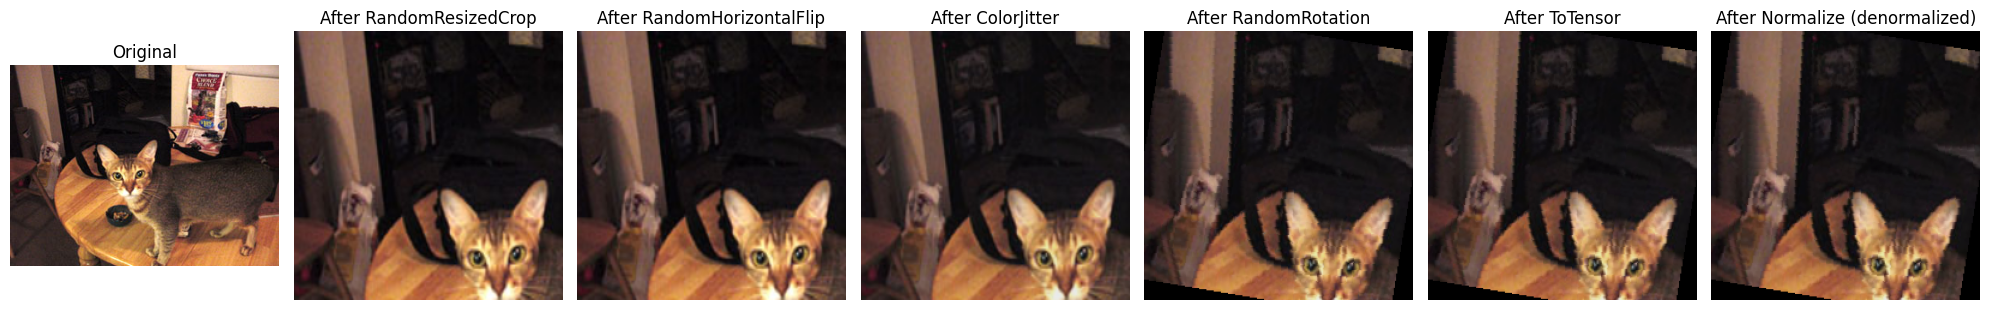

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Define the denormalization function for tensor visualization
def denormalize(tensor, mean, std):
    """Reverse normalization for visualization."""
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize: multiply by std, add mean
    return tensor

# Set paths (adjust these to match your data directory)
data_dir = "data"  # Replace with your data_dir
img_dir = os.path.join(data_dir, "images")
annotation_file = os.path.join(data_dir, "annotations", "test.txt")

# Load a sample image from the test dataset
with open(annotation_file, "r") as f:
    line = f.readline().strip()
    img_name = line.split()[0] + ".jpg"  # Assumes format: "image_name class_id ..."
img_path = os.path.join(img_dir, img_name)
image = Image.open(img_path).convert("RGB")  # Load as PIL image in RGB

# Define individual transformations from get_data_loaders
crop = transforms.RandomResizedCrop(224)
flip = transforms.RandomHorizontalFlip()
jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2)
rotate = transforms.RandomRotation(10)
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# List to store images and titles for visualization
images = []
titles = []

# Step 1: Original Image
images.append(np.array(image))
titles.append("Original")

# Step 2: RandomResizedCrop
cropped = crop(image)
images.append(np.array(cropped))
titles.append("After RandomResizedCrop")

# Step 3: RandomHorizontalFlip
flipped = flip(cropped)
images.append(np.array(flipped))
titles.append("After RandomHorizontalFlip")

# Step 4: ColorJitter
jittered = jitter(flipped)
images.append(np.array(jittered))
titles.append("After ColorJitter")

# Step 5: RandomRotation
rotated = rotate(jittered)
images.append(np.array(rotated))
titles.append("After RandomRotation")

# Step 6: ToTensor
tensor = to_tensor(rotated)
images.append(tensor.permute(1, 2, 0).numpy())  # Convert [C,H,W] to [H,W,C]
titles.append("After ToTensor")

# Step 7: Normalize (and denormalize for visualization)
normalized = normalize(tensor)
denorm = denormalize(normalized, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denorm = torch.clamp(denorm, 0, 1)  # Ensure values stay in [0,1]
images.append(denorm.permute(1, 2, 0).numpy())
titles.append("After Normalize (denormalized)")

# Create a figure with subplots to display all steps
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")  # Hide axes for cleaner display
plt.tight_layout()
plt.show()

## Model Training

We use a pre-trained ResNet34 model, modify its classifier, and train it on our dataset.

### Model Setup

- **Base Model**: ResNet34 from `torchvision`, pre-trained on ImageNet.
- **Modifications**: Replace the final fully connected layer with:
  - Dropout (0.3) to prevent overfitting.
  - Linear layer for 37 classes (Oxford Pet Dataset has 37 breeds).
- **Loss**: Cross-Entropy Loss for multi-class classification.
- **Optimizer**: SGD with momentum (0.9) and learning rate 0.015.
- **Scheduler**: Reduces learning rate when validation loss plateaus.

### Training Process

- Runs for 30 epochs.
- Tracks loss and accuracy for training and validation.
- Saves the model with a timestamp and accuracy in the filename.
- Keeps only the last 5 model checkpoints.
- Plots accuracy and loss curves.

In [ ]:
# Load data loaders
train_loader, val_loader, _ = get_data_loaders('/content/data/')
weights_dir = "/content/weights/"
os.makedirs(weights_dir, exist_ok=True)

# Load pre-trained ResNet34
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout to reduce overfitting
    nn.Linear(num_ftrs, 37)  # Output 37 classes/
)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.014, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=4)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()  # Evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)  # Adjust learning rate

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# best accuracy
last_val_acc = val_accuracies[-1]
avg_val_acc = sum(val_accuracies[-5:]) / 5

# Save model with timestamp and accuracy
timestamp = datetime.datetime.now().strftime("%d-%H")
model_filename = f"{weights_dir}resnet34_{avg_val_acc:.2f}acc_{timestamp}.pth"
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

# Keep only the last 5 models
model_files = sorted(glob.glob(f"{weights_dir}resnet34_*.pth"), key=os.path.getctime, reverse=True)
for old_file in model_files[5:]:
    os.remove(old_file)
    print(f"Deleted old model: {old_file}")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40] | Train Loss: 4.2389 | Train Acc: 6.56% | Val Loss: 3.4529 | Val Acc: 8.97%
Epoch [2/40] | Train Loss: 3.1916 | Train Acc: 15.01% | Val Loss: 3.2543 | Val Acc: 12.64%
Epoch [3/40] | Train Loss: 2.6770 | Train Acc: 23.17% | Val Loss: 2.9168 | Val Acc: 20.52%
Epoch [4/40] | Train Loss: 2.3185 | Train Acc: 32.17% | Val Loss: 3.1236 | Val Acc: 18.75%
Epoch [5/40] | Train Loss: 2.0122 | Train Acc: 39.50% | Val Loss: 2.0875 | Val Acc: 38.99%
Epoch [6/40] | Train Loss: 1.8319 | Train Acc: 44.94% | Val Loss: 2.2392 | Val Acc: 38.99%
Epoch [7/40] | Train Loss: 1.7517 | Train Acc: 46.60% | Val Loss: 1.7955 | Val Acc: 43.75%
Epoch [8/40] | Train Loss: 1.5558 | Train Acc: 52.72% | Val Loss: 1.6395 | Val Acc: 48.23%
Epoch [9/40] | Train Loss: 1.5312 | Train Acc: 53.06% | Val Loss: 1.8842 | Val Acc: 45.24%
Epoch [10/40] | Train Loss: 1.4793 | Train Acc: 55.23% | Val Loss: 1.8544 | Val Acc: 44.43%
Epoch [11/40] | Train Loss: 1.3607 | Train Acc: 58.29% | Val Loss: 1.7106 | Val Acc: 50.54%

## Testing and Evaluation

Finally, we evaluate the trained model on the test set and analyze its performance.

### Testing Process

- Loads the saved model weights.
- Runs inference on the test set.
- Collects true and predicted labels.

### Evaluation Metrics

- **Classification Report**: Shows precision, recall, and F1-score for each class.
- **Confusion Matrix**: Visualizes correct and incorrect predictions across all 37 classes.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Classification Report:
              precision    recall  f1-score   support

           0     0.7426    0.7653    0.7538        98
           1     0.5586    0.8100    0.6612       100
           2     0.6727    0.3700    0.4774       100
           3     0.7660    0.7200    0.7423       100
           4     0.6303    0.7500    0.6849       100
           5     0.6942    0.8400    0.7602       100
           6     0.7157    0.7300    0.7228       100
           7     0.8444    0.8636    0.8539        88
           8     0.7653    0.7576    0.7614        99
           9     0.7822    0.7900    0.7861       100
          10     0.7368    0.5600    0.6364       100
          11     0.8958    0.8866    0.8912        97
          12     0.7059    0.8400    0.7671       100
          13     0.7565    0.8700    0.8093       100
          14     0.7387    0.8200    0.7773       100
          15     0.7500    0.7500    0.7500       100
          16     0.7130    0.8200    0.7628       100
   

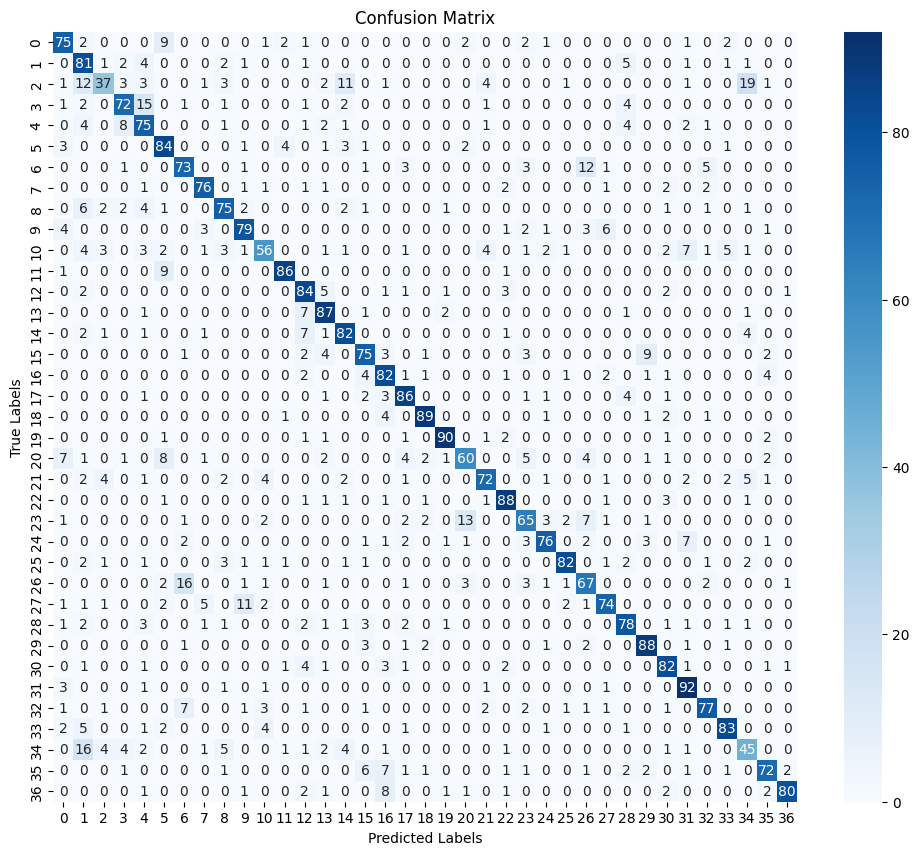

In [ ]:
# Load test data
_, _, test_loader = get_data_loaders(data_dir)

# Load model
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout is disabled in eval mode
    nn.Linear(num_ftrs, 37)
)
model_path = f"{weights_dir}best_model.pth"  # Update with your model file
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Test the model
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(37), yticklabels=np.arange(37))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

--2025-03-16 18:51:29--  https://drive.usercontent.google.com/download?id=1nIguVe7IDSwhm96F-p0knx1uDfXB5S9f
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2373 (2.3K) [text/html]
Saving to: ‘download?id=1nIguVe7IDSwhm96F-p0knx1uDfXB5S9f’

download?id=1nIguVe 100%[===================>]   2.32K  --.-KB/s    in 0s      

2025-03-16 18:51:30 (22.1 MB/s) - ‘download?id=1nIguVe7IDSwhm96F-p0knx1uDfXB5S9f’ saved [2373/2373]



In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
# Load the trained model
model = torch.load("weights/best_model.pth", map_location=torch.device('cpu'))
model.eval()

# Define the transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Load a dataset (update the path to your dataset)
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Select a subset of samples for visualization
indices = np.random.choice(len(dataset), 6, replace=False)  # Pick 6 random indices
samples = [dataset[i] for i in indices]

FileNotFoundError: [Errno 2] No such file or directory: 'weights/best_model.pth'

In [ ]:
# Extract images and ground truth labels
images, labels = zip(*samples)

# Stack images into a tensor
input_tensor = torch.stack(images)  # Shape: (6, 3, 224, 224)